## Simulate a DMP-SBM

First import the library `dmprdpg`.

In [1]:
import dmprdpg

Assume $K=3$ layers and $T=3$ time points, and $G=G^\prime=4$, representing the number of communities. Define a dictionary of $G\times G^\prime$ between-community probability matrices (essentially representing a $G\times G\times K\times T$ tensor). 

In [2]:
# Pre-define matrix B - Index is (layer, time)
import numpy as np
B_dict = {
    (0, 0): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (0, 1): np.array([[0.16, 0.16, 0.04, 0.10], [0.16, 0.16, 0.04, 0.10], [0.04, 0.04, 0.09, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (0, 2): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 0): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 1): np.array([[0.16, 0.16, 0.04, 0.10], [0.16, 0.16, 0.04, 0.10], [0.04, 0.04, 0.09, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 2): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (2, 0): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]]),
    (2, 1): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]]),
    (2, 2): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]])
}
BB = dmprdpg.double_unfolding(B_dict, rows=3, cols=3, n=4, output='dense')

In [3]:
## Truncated SVD of order 4 of BB
from scipy.sparse.linalg import svds
U, S, V = svds(BB, k=4)
mu = U[:,::-1] @ np.diag(S[::-1] ** .5)
lam = V[::-1].T @ np.diag(S[::-1] ** .5)

Using the functions in `dmprdpg`, sample a DMP-SBM via the function `simulate_dpsbm`, using `B_dict`.

In [4]:
A_dict, z, z_prime = dmprdpg.simulate_dmpsbm(n=1000, B_dict=B_dict, seed=107)


Calculate the DUASE from the sampled adjacency matrices, using the function `duase` in `dmprdpg`. 

In [5]:
X, Y = dmprdpg.duase(A_dict, K=3, T=3, d=4)

In [6]:
## Averages of X and Y per group (z and z_prime)
X_avg = np.zeros((4,4,3))
Y_avg = np.zeros((4,4,3))
for i in range(4):
    X_avg[i] = np.mean(X[z == i], axis=0)
    Y_avg[i] = np.mean(Y[z_prime == i], axis=0)


In [7]:
## Make X_avg2 and Y_avg2 (12,4) arrays
X_avg2 = np.zeros((12, 4))
Y_avg2 = np.zeros((12, 4))
for i in range(12):
    X_avg2[i] = X_avg[i % 4][:, i // 4]
    Y_avg2[i] = Y_avg[i % 4][:, i // 4]
## Stack X_avg2 and Y_avg2
XY_avg2 = np.vstack((X_avg2, Y_avg2))
## Stack mu and lam
mu_lam = np.vstack((mu, lam))
## Procrustes between concatenations (X_avg2,Y_avg2) and (mu,lam)
from scipy.linalg import orthogonal_procrustes
R, _ = orthogonal_procrustes(XY_avg2, mu_lam)
## Apply R and scale to mu and lam
mu_lam2 = mu_lam @ R
## Create mu2 and lam2 (4,4,3) arrays
mu2 = np.zeros((4, 4, 3))
lam2 = np.zeros((4, 4, 3))
for i in range(12):
    mu2[i % 4, :, i // 4] = mu_lam2[:12][i]
    lam2[i % 4, :, i // 4] = mu_lam2[12:][i]



Plot the output of DUASE.

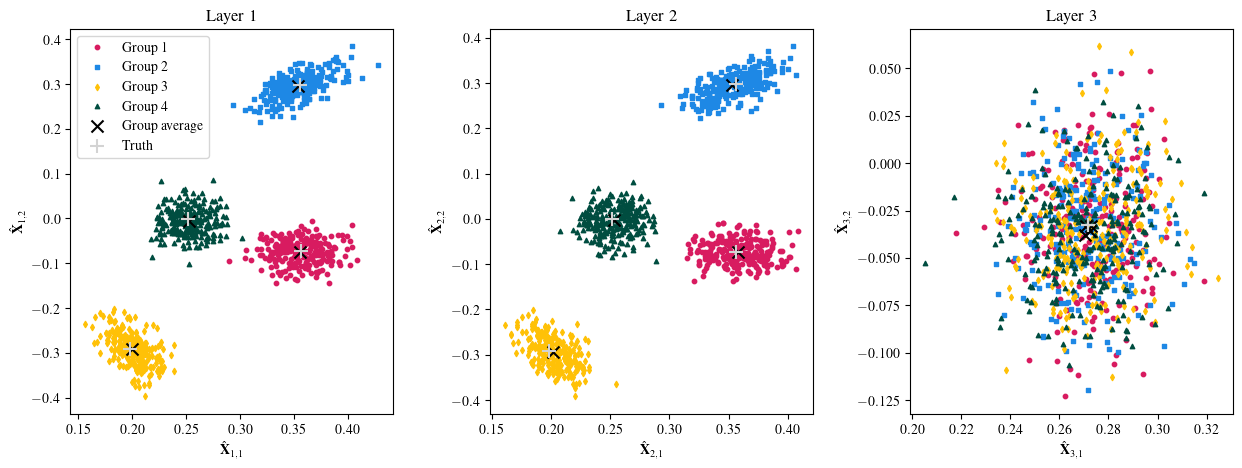

In [8]:
import matplotlib.pyplot as plt
## Compile with tikz and times font
plt.rc('text', usetex=True)
plt.rc('font', family='times')
## Plot all layers in different subfigures
fig, axs = plt.subplots(1,3, figsize=(15, 5))
cols = np.array(['#D81B60', '#1E88E5', '#FFC107', '#004D40'])
mars = np.array(['o', 's', 'd', '^'])
## Slightly augment distance between subfigures
plt.subplots_adjust(wspace=0.3)
for k in range(3):
    for i in range(4):
        axs[k].scatter(X[z == i, 0, k], X[z == i, 1, k], c=cols[i], s=10, marker=mars[i])
    axs[k].set_title(f"Layer {k+1}")
    ## Axis labels
    axs[k].set_xlabel(r"$\hat{\mathbf{X}}_{" + str(k+1) + ",1}$")
    axs[k].set_ylabel(r"$\hat{\mathbf{X}}_{" + str(k+1) + ",2}$")
    ## Add average per group and "truth"
    for i in range(4):
        axs[k].scatter(X_avg[i,0,k], X_avg[i,1,k], c='black', s=75, marker='x')
        axs[k].scatter(mu2[i,0,k], mu2[i,1,k], c='lightgray', s=100, marker='+')
    ## Only plot legend in first subfigure
    if k == 0:
        axs[k].legend([f"Group {i+1}" for i in range(4)] + ["Group average", "Truth"], loc='upper left')
## Save plot
plt.savefig("figures/duase_layers_sbm.pdf", bbox_inches='tight')
plt.show()

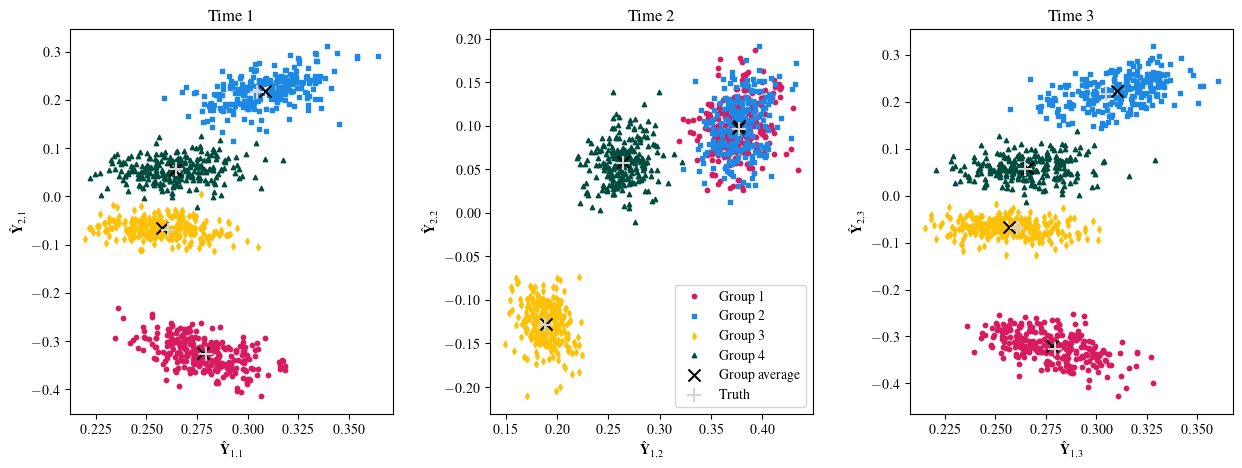

In [9]:
## Repeat for different times
fig, axs = plt.subplots(1,3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
for t in range(3):
    for i in range(4):
        axs[t].scatter(Y[z_prime == i, 0, t], Y[z_prime == i, 1, t], c=cols[i], s=10, marker=mars[i])
    axs[t].set_title(f"Time {t+1}")
    axs[t].set_xlabel(r"$\hat{\mathbf{Y}}_{1," + str(t+1) + "}$")
    axs[t].set_ylabel(r"$\hat{\mathbf{Y}}_{2," + str(t+1) + "}$")
    for i in range(4):
        axs[t].scatter(Y_avg[i,0,t], Y_avg[i,1,t], c='black', s=75, marker='x')
        axs[t].scatter(lam2[i,0,t], lam2[i,1,t], c='lightgray', s=100, marker='+')
    ## Add legend only in second subfigure
    if t == 1:
        axs[t].legend([f"Group {i+1}" for i in range(4)] + ["Group average", "Truth"], loc='lower right')
plt.savefig("figures/duase_time_sbm.pdf", bbox_inches='tight')
plt.show()

Apply classic multidimensional scaling on the distance matrix obtained from the right embedding $\hat{\mathbf{Y}}_t,\ t=1,\dots,T$, followed by ISOMAP.

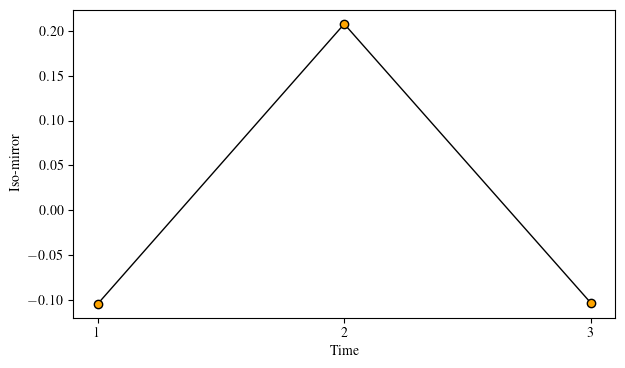

In [13]:
D = dmprdpg.distance_matrix_tensor(Y)
C = dmprdpg.cmds(D, 2)
U = dmprdpg.isomap(C, 2, 1)
## Orange for points, black for line and point
plt.figure(figsize=(7,4))
plt.plot(np.arange(3)+1, U, marker='o', color='black', markerfacecolor='orange', lw=1)
plt.xticks(np.arange(3)+1)
plt.xlabel("Time")
plt.ylabel("Iso-mirror")
plt.savefig("figures/mirror_sbm_time.pdf", bbox_inches='tight')
plt.show()

This is also unified in the function `mirror` in `dmprdpg`:

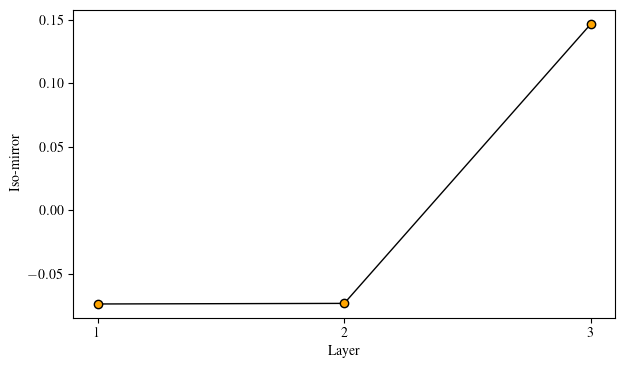

In [14]:
V = dmprdpg.mirror(X, n_neighbors=2, n_components_cmds=2, n_components_isomap=1)
plt.figure(figsize=(7,4))
plt.plot(np.arange(3)+1, V, marker='o', color='black', markerfacecolor='orange', lw=1)
plt.xticks(np.arange(3)+1)
plt.xlabel("Layer")
plt.ylabel("Iso-mirror")
plt.savefig("figures/mirror_sbm_layers.pdf", bbox_inches='tight')
plt.show()